<a href="https://colab.research.google.com/github/hy30n80/KERC2022/blob/main/Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 453 kB 38.8 MB/s 


In [39]:
from google.colab import drive
drive.mount('/content/drive')

from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from tensorflow.keras.layers import(Input, Dense, Bidirectional, LSTM, Concatenate, concatenate, Embedding, Dropout)
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
train_x_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_data.tsv'
train_y_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_labels.csv'

In [34]:
EMBEDDING_DIM=100
MAXLEN = 30
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = '<OOV>'
NUM_WORDS = 15000
SPLIT_SIZE = 0.9

In [36]:
train_data = pd.read_csv(train_x_path, sep='\t')
labels = pd.read_csv(train_y_path)
#label csv 를 train_data에 병합
train_data['label'] = labels['label']
print(train_data[:5])
print(len(train_data))
print(train_data.isnull().sum())

   sentence_id person                                           sentence  \
0            1     어영  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2     어영     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3    지구대                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4     순경                                         근무중인데 어딜가?   
4            5    지구대    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0  S0104                                              NaN  dysphoria  
1  S0108         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  
7339
0       dysphoria
1       dysphoria
2         neutral
3       dysphoria
4        euphoria
          ...    
7334

In [37]:
#context null 값 '결측' 으로 채우기
train_data['context'].fillna('결측', inplace=True)
print(train_data.isnull().sum())

sentence_id    0
person         0
sentence       0
scene          0
context        0
label          0
dtype: int64


In [38]:
# person, scene category 변형
train_data['person'].value_counts()
train_data['scene'].value_counts()
train_data['person'] = train_data['person'].astype('category')
train_data['scene'] = train_data['scene'].astype('category')


train_data['person']= train_data['person'].cat.codes
train_data['scene']= train_data['scene'].cat.codes
print(train_data[:5])

   sentence_id  person                                           sentence  \
0            1      42  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2      42     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3      69                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4      36                                         근무중인데 어딜가?   
4            5      69    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context      label  
0      0                                               결측  dysphoria  
1      1         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  dysphoria  
2      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대    neutral  
3      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  dysphoria  
4      2  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대   euphoria  


In [42]:
#전체 data 셔플
train_data=sklearn.utils.shuffle(train_data)
print(train_data)


      sentence_id  person                                           sentence  \
806          1372      48                                         그럴틈도 없었어요.   
5015         8275      30         박쥐꼴 나게 생겼어요. 의심하는 눈치에요. 경찰들이라 어찌나 눈치가 빠른지.   
5540         9253      83                                              그러든가.   
5384         8910      73                                             목적이라니?   
2334         3852       1                       예? 주유소라면, 주유소 관리를 맡아서 하라는...   
...           ...     ...                                                ...   
2274         3761      83                                       우리가 애냐? 싸우게.   
2184         3639      31  누가 니 장인어른이야? 넌 울아부지 얼굴에 먹칠하고 내 얼굴에 똥칠했어. 세상에 태...   
4727         7789      48                                          출근 안하셨어요?   
3920         6560       5               꼭 부모가 입 뚜들겨야 된다니. 알아서 형좀 챙기면 얼마나 좋아.   
4818         7907      72                                                말면?   

      scene                            

In [43]:
# Stopwords 는 우선 고려하지 않고 실행
# sentence , context 문자열 데이터로 처리
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()

tok_sentences = []
for sen in tqdm(train_data['sentence']):
  tok_sen = okt.morphs(sen)
  tok_sentences.append(tok_sen)

tok_contexts = []
for con in tqdm(train_data['context']):
  tok_con = okt.morphs(con)
  tok_contexts.append(tok_con)

100%|██████████| 7339/7339 [00:14<00:00, 491.43it/s]


[['그럴', '틈', '도', '없었어요', '.'], ['박쥐', '꼴', '나게', '생겼어요', '.', '의심', '하는', '눈치', '에요', '.', '경찰', '들', '이라', '어찌나', '눈치', '가', '빠른지', '.'], ['그러든', '가', '.'], ['목적', '이라니', '?'], ['예', '?', '주유소', '라면', ',', '주유소', '관리', '를', '맡아서', '하라', '는', '...']]
문장 최대 길이:  73
문장 평균 길이:  12.137212154244448


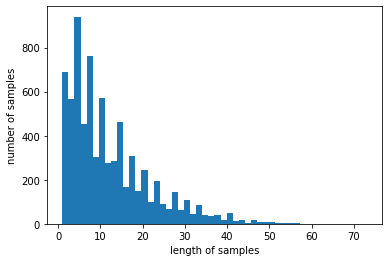

문맥 최대 길이:  8
문맥 평균 길이:  10.46000817550075


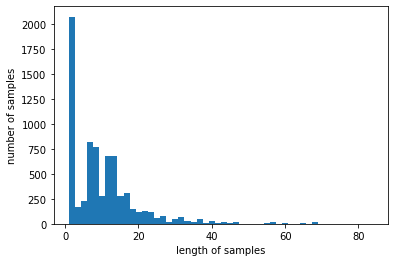

In [44]:
print(tok_sentences[:5])

print('문장 최대 길이: ', max(len(sen) for sen in tok_sentences))
print('문장 평균 길이: ', sum(map(len, tok_sentences))/len(tok_sentences))
plt.hist([len(sen) for sen in tok_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('문맥 최대 길이: ', max(len(con) for sen in tok_contexts))
print('문맥 평균 길이: ', sum(map(len, tok_contexts))/len(tok_contexts))
plt.hist([len(con) for con in tok_contexts], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [45]:
# sentence, context 각각 tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def fit_and_seq(train_sentences, oov_token, maxlen, padding, truncating):
  
  tokenizer = Tokenizer(oov_token = oov_token)
  tokenizer.fit_on_texts(train_sentences)
  
  sequences= tokenizer.texts_to_sequences(train_sentences)
  pad_trunc_sequences= pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

  return pad_trunc_sequences, tokenizer

"""
def tokenize_label(labels):

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)

  label_seq = label_tokenizer.texts_to_sequences(labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np, label_tokenizer
"""


'\ndef tokenize_label(labels):\n\n  label_tokenizer = Tokenizer()\n  label_tokenizer.fit_on_texts(labels)\n\n  label_seq = label_tokenizer.texts_to_sequences(labels)\n  label_seq_np = np.array(label_seq)-1\n\n  return label_seq_np, label_tokenizer\n'

In [46]:
train_sentence_seq, tokenizer = fit_and_seq(tok_sentences, OOV_TOKEN, MAXLEN, PADDING, TRUNCATING)
train_context_seq, _ = fit_and_seq(tok_contexts, OOV_TOKEN, MAXLEN, PADDING, TRUNCATING)

In [47]:
word_index = tokenizer.word_index
print(train_sentence_seq[3])
print(word_index['근무'])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 2015
 1167    3]
539


In [14]:
""" 
train_label_seq, label_tokenizer = tokenize_label(np.array(labels['label']))
label_word_index = label_tokenizer.word_index
print(train_label_seq[1])
print(label_word_index)
"""

" \ntrain_label_seq, label_tokenizer = tokenize_label(np.array(labels['label']))\nlabel_word_index = label_tokenizer.word_index\nprint(train_label_seq[1])\nprint(label_word_index)\n"

In [48]:
#label 값 0,1,2 로 Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train_data['label'])

train_label_seq = le.transform(train_data['label'])
print(le.classes_)
print(train_label_seq)

['dysphoria' 'euphoria' 'neutral']
[2 0 1 ... 0 0 0]


In [16]:
"""
def train_val_split(sentences, labels, training_split):

  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]


  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels
"""

'\ndef train_val_split(sentences, labels, training_split):\n\n  train_size = int(len(sentences)*training_split)\n\n  train_sentences = sentences[:train_size]\n  train_labels = labels[:train_size]\n\n\n  val_sentences = sentences[train_size:]\n  val_labels = labels[train_size:]\n\n  return train_sentences, train_labels, val_sentences, val_labels\n'

In [49]:
print(type(np.array(train_data['person'])), type(train_sentence_seq),type(train_context_seq), type(train_data['scene']) )

print(np.array(train_data['person']).shape)
print(train_sentence_seq.shape)
print(np.array(train_data['person']))
print(train_sentence_seq)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
(7339,)
(7339, 30)
[48 30 83 ... 48  5 72]
[[   0    0    0 ...    8 2507    2]
 [   0    0    0 ...    6 5097    2]
 [   0    0    0 ... 3304    6    2]
 ...
 [   0    0    0 ...    9  781    3]
 [   0    0    0 ...  126  262    2]
 [   0    0    0 ...   12   74    3]]


In [50]:
#Data split 
from sklearn.model_selection import train_test_split
train_sentences, test_sentences = train_test_split(train_sentence_seq, test_size=0.1, shuffle=False)
train_contexts, test_contexts = train_test_split(train_context_seq, test_size=0.1, shuffle=False)
train_people, test_people = train_test_split(np.array(train_data['person']), test_size=0.1, shuffle=False)
train_scenes, test_scenes = train_test_split(np.array(train_data['scene']), test_size=0.1, shuffle=False)
train_labels, test_labels = train_test_split(train_label_seq, test_size=0.1, shuffle=False)

In [57]:

print(train_sentences.shape)
print(train_contexts.shape)
print(train_people.shape)
print(train_scenes.shape)
print(train_labels.shape)

print(test_sentences.shape)
print(test_contexts.shape)
print(test_people.shape)
print(test_scenes.shape)
print(test_labels.shape)



(6605, 30)
(6605, 30)
(6605,)
(6605,)
(6605,)
(734, 30)
(734, 30)
(734,)
(734,)
(734,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [62]:
def create_model(num_words, embedding_dim, maxlen):
  

  input_P = Input(shape=[1], name = "input_person")
  input_S = Input(shape=[1], name = "input_scene")
  input_sen = Input(shape=[30], name = "input_sentence")
  input_con = Input(shape=[30], name = "input_context")

  Dense_p1 = Dense(8, activation = 'relu')(input_P)
  Dense_p2 = Dense(1, activation = 'sigmoid')(Dense_p1)

  Dense_s1 = Dense(8, activation = 'relu')(input_S)
  Dense_s2 = Dense(1, activation = 'sigmoid')(Dense_s1)

  Embedding1 = Embedding(num_words, embedding_dim, input_length=maxlen)(input_sen)
  LSTM_sen = Bidirectional(LSTM(16, return_sequences=False))(Embedding1)
  Dense_sen = Dense(16, activation = 'sigmoid')(LSTM_sen)

  Embedding2 = Embedding(num_words, embedding_dim, input_length=maxlen)(input_con)
  LSTM_con = Bidirectional(LSTM(16, return_sequences=False))(Embedding2)
  Dense_con = Dense(16, activation = 'sigmoid')(LSTM_con)

  
  concat = concatenate([Dense_p2, Dense_s2, Dense_sen, Dense_con], name='concat')
  Drp1 = Dropout(0.3)(concat)
  Dense1 = Dense(16, activation = 'relu')(concat)
  Dense2 = Dense(8, activation = 'relu')(Dense1)
  Drp2 = Dropout(0.3)(Dense2)
  output = Dense(3, activation = 'softmax')(Dense2)


  model = tf.keras.Model(inputs =[input_P, input_S, input_sen, input_con], outputs=[output])


  return model


In [63]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_sentence (InputLayer)    [(None, 30)]         0           []                               
                                                                                                  
 input_context (InputLayer)     [(None, 30)]         0           []                               
                                                                                                  
 input_person (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 input_scene (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [68]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4*10**(epoch/10))
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)


In [69]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
history = model.fit((train_people, train_scenes, train_sentences, train_contexts), train_labels, epochs=30, 
                    validation_data = ((test_people, test_scenes, test_sentences, test_contexts), test_labels), callbacks=[lr_schedule])

Epoch 1/30
207/207 [==============================] - 37s 91ms/step - loss: 1.1030 - accuracy: 0.4250 - val_loss: 0.9425 - val_accuracy: 0.6403 - lr: 1.0000e-04
Epoch 2/30
207/207 [==============================] - 16s 76ms/step - loss: 0.9183 - accuracy: 0.6141 - val_loss: 0.8726 - val_accuracy: 0.6403 - lr: 1.2589e-04
Epoch 3/30
207/207 [==============================] - 18s 85ms/step - loss: 0.8764 - accuracy: 0.6141 - val_loss: 0.8199 - val_accuracy: 0.6403 - lr: 1.5849e-04
Epoch 4/30
207/207 [==============================] - 17s 80ms/step - loss: 0.7859 - accuracy: 0.6964 - val_loss: 0.7144 - val_accuracy: 0.7452 - lr: 1.9953e-04
Epoch 5/30
207/207 [==============================] - 16s 76ms/step - loss: 0.6842 - accuracy: 0.7403 - val_loss: 0.6499 - val_accuracy: 0.7589 - lr: 2.5119e-04
Epoch 6/30
207/207 [==============================] - 16s 75ms/step - loss: 0.5455 - accuracy: 0.7920 - val_loss: 0.6396 - val_accuracy: 0.7507 - lr: 3.1623e-04
Epoch 7/30
207/207 [==============

In [56]:
result = model.predict((train_people, train_scenes, train_sentences, train_contexts))
predict = tf.argmax(result, axis=1)
print(predict)

tf.Tensor([2 0 1 ... 0 2 1], shape=(6605,), dtype=int64)
